# Project: Wrangling and Analyze Data

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import tweepy as tp
from tweepy import OAuthHandler
import json
import os
from timeit import default_timer as timer
import black
from bs4 import BeautifulSoup
import re
from IPython.display import Image
from matplotlib import pyplot as plt
import seaborn as sns

## Creating Used Functions

In [2]:
def get_url_elements(row):
    soup = BeautifulSoup(row["source"], "html")
    row["tweet_source"] = soup.find("a").contents[0]
    row["url_ref"] = soup.find("a").get("href")
    row["rel"] = soup.find("a").get("rel")[0]
    return row

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
df_werated = pd.read_csv(os.path.join(os.getcwd(), "twitter-archive-enhanced.csv"))
df_werated.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
file_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = rq.get(file_url)

In [5]:
with open(os.path.join(os.getcwd(), file_url.split("/")[-1]), "wb") as file:
    file.write(r.content)

In [6]:
df_img_pred = pd.read_csv("image-predictions.tsv", sep="\t")

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

> Even though my request for the student access to Tweepy was refused, I will describe how I would suppose to fetch the required data in the following cells. Then the actual extraction will happen with the file `tweet-json.txt`

In [7]:
consumer_key = "HIDDEN"
consumer_secret = "HIDDEN"
access_token = "HIDDEN"
access_secret = "HIDDEN"
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tp.API(auth, wait_on_rate_limit=True)

In [8]:
tweet_ids = df_werated.tweet_id.values
len(tweet_ids)

2356

In [9]:
count = 0
fails_dict = {}
start = timer()
with open("tweet_json.txt", "w") as outfile:
    for tweet_id in tweet_ids:
        count += 1

        try:
            tweet = api.get_status(tweet_id, tweet_mode="extended")
            json.dump(tweet._json, outfile)
            outfile.write("\n")
        except tp.TweepyException as e:
            fails_dict[tweet_id] = e
            pass
end = timer()
print(f"Total elapsed time: {end - start} seconds")

Total elapsed time: 710.6608249999999 seconds


len(fails_dict.keys())

> Notice that all the tweets failed, because of user permissions. Therefore, I will use the `tweet-json.txt`  file content


In [10]:
file_url = "https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt"
r = rq.get(file_url)
with open(os.path.join(os.getcwd(), file_url.split("/")[-1]), "wb") as file:
    file.write(r.content)

> Let's open the first line of the json file just to see the structure of the json file and if it has all the necessary fields

In [11]:
with open("tweet-json.txt", "r") as j:
    json_1st_line = json.loads(j.readlines(1)[0])

In [12]:
json_1st_line

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'medium': {'w': 

In [13]:
json_1st_line["entities"]["media"][0]["expanded_url"]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [14]:
# Checking if all the columns can be found.
all(elem in json_1st_line.keys() for elem in ["id", "retweet_count", "favorite_count"])

True

> All columns found. Except the `tweet_id`, which is equivalent to `id`

In [15]:
tweets_dict = {
    "tweet_id": [],
    "retweet_count": [],
    "favorite_count": [],
    "followers_count": [],
    "friends_count": [],
    "source": [],
    "retweeted_status": [],
}
with open("tweet-json.txt", "r") as j:
    for l in j.readlines():
        r = json.loads(l)
        tweets_dict["tweet_id"].append(r["id"])
        tweets_dict["retweet_count"].append(r["retweet_count"])
        tweets_dict["favorite_count"].append(r["favorite_count"])
        tweets_dict["followers_count"].append(r["user"]["followers_count"])
        tweets_dict["friends_count"].append(r["user"]["friends_count"])
        tweets_dict["source"].append(r["source"])
        rt_status = r.get("retweeted_status")
        if not rt_status:
            rt_status = "Original Tweet"
        else:
            rt_status = "Retweet"
        tweets_dict["retweeted_status"].append(rt_status)

In [16]:
df_tweet_details = pd.DataFrame(tweets_dict)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual Assessment

In [17]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [18]:
df_werated

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
19    888202515573088257                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
22    887517139158093824                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
24    887343217045368832                    NaN                  NaN   
25    887101392804085760                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
28    886680336477933568                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
30    886267009285017600           8.862664e+17         2.281182e+09   
31    886258384151887873                    NaN                  NaN   
32    886054160059072513                    NaN                  NaN   
33    885984800019947520                    NaN                  NaN   
34    885528943205470208                    NaN                  NaN   
35    885518971528720385                    NaN                  NaN   
36    885311592912609280                    NaN                  NaN   
37    885167619883638784                    NaN                  NaN   
38    884925521741709313                    NaN                  NaN   
39    884876753390489601                    NaN                  NaN   
40    884562892145688576                    NaN                  NaN   
41    884441805382717440                    NaN                  NaN   
42    884247878851493888                    NaN                  NaN   
43    884162670584377345                    NaN                  NaN   
44    883838122936631299                    NaN                  NaN   
45    883482846933004288                    NaN                  NaN   
46    883360690899218434                    NaN                  NaN   
47    883117836046086144                    NaN                  NaN   
48    882992080364220416                    NaN                  NaN   
49    882762694511734784                    NaN                  NaN   
50    882627270321602560                    NaN                  NaN   
51    882268110199369728                    NaN                  NaN   
52    882045870035918850                    NaN                  NaN   
53    881906580714921986                    NaN                  NaN   
54    881666595344535552                    NaN         

In [19]:
df_img_pred

tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    666071193221509120    https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg   
12    666073100786774016    https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg   
13    666082916733198337    https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg   
14    666094000022159362    https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg   
15    666099513787052032    https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg   
16    666102155909144576    https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg   
17    666104133288665088    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18    666268910803644416    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
19    666273097616637952    https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg   
20    666287406224695296    https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg   
21    666293911632134144    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
22    666337882303524864    https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg   
23    666345417576210432    https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg   
24    666353288456101888    https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg   
25    666362758909284353    https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
26    666373753744588802    https://pbs.twimg.com/media/CT9vZEYWUAAlZ05.jpg   
27    666396247373291520    https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg   
28    666407126856765440    https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg   
29    666411507551481857    https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg   
30    666418789513326592    https://pbs.twimg.com/media/CT-YWb7U8AA7QnN.jpg   
31    666421158376562688    https://pbs.twimg.com/media/CT-aggCXAAIMfT3.jpg   
32    666428276349472768    https://pbs.twimg.com/media/CT-g-0DUwAEQdSn.jpg   
33    666430724426358785    https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg   
34    666435652385423360    https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg   
35    666437273139982337    https://pbs.twimg.com/media/CT-pKmRWIAAxUWj.jpg   
36    666447344410484738    https://pbs.twimg.com/media/CT-yU5QWwAEjLX5.jpg   
37    666454714377183233    https://pbs.twimg.com/media/CT-5Bs-WUAA2JeC.jpg   
38    666644823164719104    https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg   
39    666649482315059201    https://pbs.twimg.com/media/CUBqKnLWwAA5OQB.jpg   
40    666691418707132416    https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg   
41    666701168228331520    https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg   
42    666739327293083650    https://pbs.twimg.com/media/CUC74aTWoAInZey.jpg   
43    666776908487630848    https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg   
44    666781792255496192    https://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg   
45    666786068205871104    https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg   
46    666804364988780544    https://pbs.twimg.com/media/CUD3A7YWoAA82N0.jpg   
47    666817836334096384    https://pbs.twimg.com/media/CUEDSMEWEAAuXVZ.jpg   
48    666826780179869698    https://pbs.twimg.com/media/CUELa0NUkAAscGC.jpg   
49    666835007768551424    https://pbs.twimg.com/media/CUES51dXIA

In [20]:
df_tweet_details

tweet_id  retweet_count  favorite_count  followers_count  \
0     892420643555336193           8853           39467          3200889   
1     892177421306343426           6514           33819          3200889   
2     891815181378084864           4328           25461          3200889   
3     891689557279858688           8964           42908          3200889   
4     891327558926688256           9774           41048          3200889   
5     891087950875897856           3261           20562          3200889   
6     890971913173991426           2158           12041          3200889   
7     890729181411237888          16716           56848          3200889   
8     890609185150312448           4429           28226          3200889   
9     890240255349198849           7711           32467          3200889   
10    890006608113172480           7624           31166          3200889   
11    889880896479866881           5156           28268          3200889   
12    889665388333682689           8538           38818          3200889   
13    889638837579907072           4735           27672          3200889   
14    889531135344209921           2321           15359          3200889   
15    889278841981685760           5637           25652          3200889   
16    888917238123831296           4709           29611          3200889   
17    888804989199671297           4559           26080          3200889   
18    888554962724278272           3732           20290          3200889   
19    888078434458587136           3653           22201          3200889   
20    887705289381826560           5609           30779          3200890   
21    887517139158093824          12082           46959          3200890   
22    887473957103951883          18781           69871          3200890   
23    887343217045368832          10737           34222          3200890   
24    887101392804085760           6167           31061          3200890   
25    886983233522544640           8084           35859          3200890   
26    886736880519319552           3443           12306          3200890   
27    886680336477933568           4610           22798          3200890   
28    886366144734445568           3316           21524          3200890   
29    886267009285017600              4             117          3200890   
30    886258384151887873           6523           28469          3200890   
31    886054160059072513            108               0          3200890   
32    885984800019947520           7097           33382          3200890   
33    885528943205470208           6683           36689          3200890   
34    885518971528720385           3899           20788          3200890   
35    885311592912609280          19297               0          3200890   
36    885167619883638784           4556           22367          3200890   
37    884925521741709313          16439           68152          3200890   
38    884876753390489601           6096           28514          3200890   
39    884562892145688576           5100           24765          3200890   
40    884441805382717440           5856           27478          3200890   
41    884247878851493888          21298           74423          3200890   
42    884162670584377345           3128           20771          3200890   
43    883838122936631299           3586           22349          3200890   
44    883482846933004288          10407           46860          3200890   
45    883360690899218434           3825           22986          3200890   
46    883117836046086144           6949           37914          3200890   
47    882992080364220416           4122           24445          3200890   
48    882762694511734784           5134           28903          3200890   
49    882627270321602560           6342           28382          3200890   
50    882268110199369728          12118           45880          3200890   
51    882045870035918850           5203           29900         

In [21]:
# Returning df view to standard in order to save memory
pd.reset_option("all", silent=True)

### Programatic Assessment

In [22]:
df_werated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [23]:
# Looking for duplicated values
df_werated.tweet_id.duplicated().sum()

0

In [24]:
# Checking the profile of the columns that should remain numeric
df_werated[["rating_numerator", "rating_denominator"]].describe()

rating_numerator  rating_denominator
count       2356.000000         2356.000000
mean          13.126486           10.455433
std           45.876648            6.745237
min            0.000000            0.000000
25%           10.000000           10.000000
50%           11.000000           10.000000
75%           12.000000           10.000000
max         1776.000000          170.000000

In [25]:
df_werated.query("rating_denominator > 10").text.shape[0]

20

In [26]:
for i in df_werated.query("rating_denominator > 10").index:
    print(f"row: {i}", "-->", df_werated.text[i])

row: 342 --> @docmisterio account started on 11/15/15
row: 433 --> The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
row: 784 --> RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
row: 902 --> Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
row: 1068 --> After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
row: 1120 --> Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
row: 1165 --> Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
row: 1202 --> This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
row: 1228 --> Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody h

In [27]:
df_werated.iloc[[784, 1202, 1662], :][
    ["tweet_id", "rating_numerator", "rating_denominator"]
]

tweet_id  rating_numerator  rating_denominator
784   775096608509886464                 9                  11
1202  716439118184652801                50                  50
1662  682962037429899265                 7                  11

> Unfortunately the cases of the tweets above are situations which is not possible to fix programatically (At least not with 100% success), however, it will be corrected manually to the information provided in the text. To facilitate the job, a df will be created to help in following which tweets to correct

In [28]:
df_tweets_to_correct = pd.DataFrame(
    {
        "tweet_id": ["775096608509886464", "716439118184652801", "682962037429899265"],
        "new_numerator": [14, 11, 10],
        "new_denominator": [10, 10, 10],
    }
)

In [29]:
df_werated.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [30]:
df_werated.query("rating_numerator >= 100").text.shape[0]

11

In [31]:
df_werated.query("rating_numerator < 10").text.shape[0]

440

In [32]:
for i in df_werated.query("rating_numerator >= 100").index:
    print(f"row: {i}", "-->", df_werated.text[i], "--", df_werated.rating_numerator[i])

row: 188 --> @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research -- 420
row: 189 --> @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10 -- 666
row: 290 --> @markhoppus 182/10 -- 182
row: 313 --> @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho -- 960
row: 902 --> Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE -- 165
row: 979 --> This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh -- 1776
row: 1120 --> Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv -- 204
row: 1634 --> Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3 -- 143
row: 1635 --> Someone help the girl is being mugged. Several are distracting her while two 

In [33]:
# Checking if there is decimal numerators in the text

df_werated.text.str.findall("\d+\.\d+\/\d+").sum()

['13.5/10', '9.75/10', '9.75/10', '11.27/10', '9.5/10', '11.26/10']

In [34]:
# Checking if there is decimal denominators in the text as well
df_werated.text.str.findall("\d+/\d+\.\d+").sum()

[]

row: 1734 --> This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP


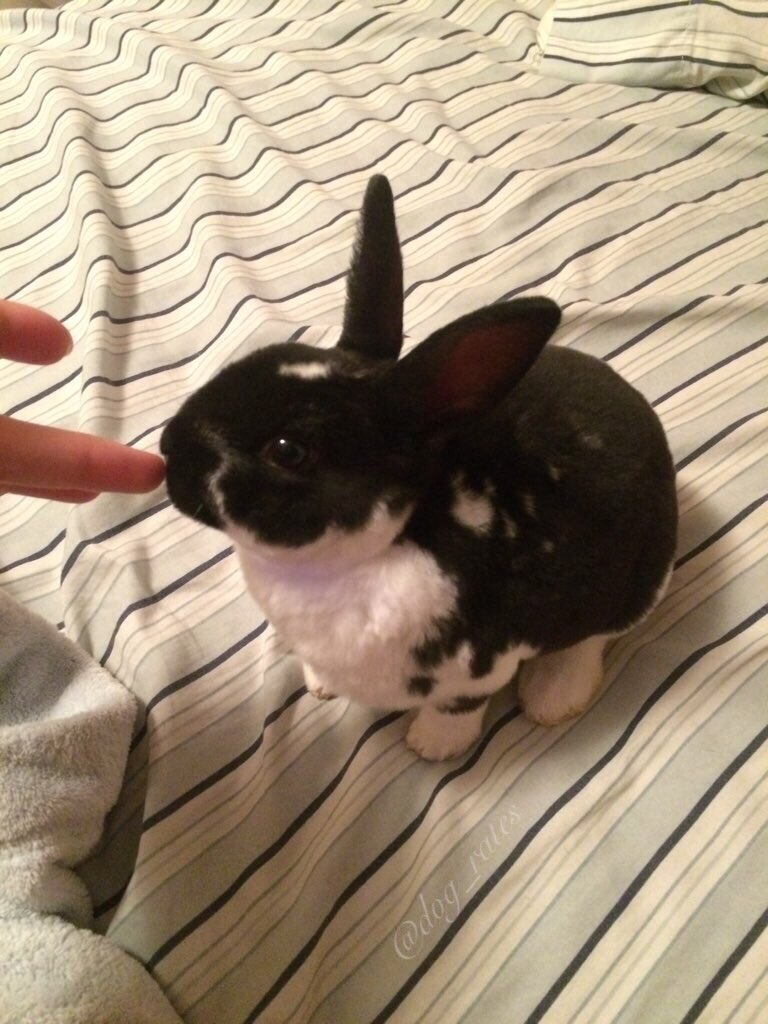

row: 1837 --> "Yes hello I'ma just snag this here toasted bagel real quick. carry on." 9/10 https://t.co/Cuz0Osnekp


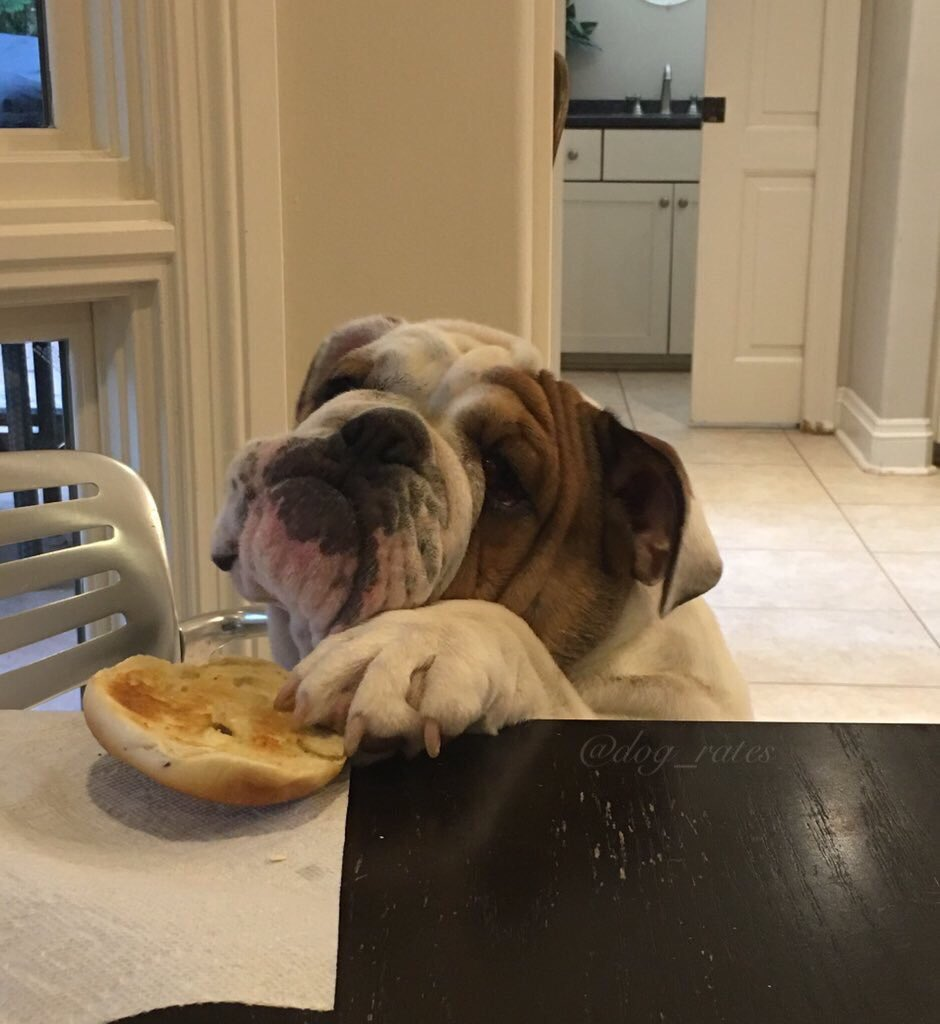

row: 936 --> This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.co/3r7wjfsXHc


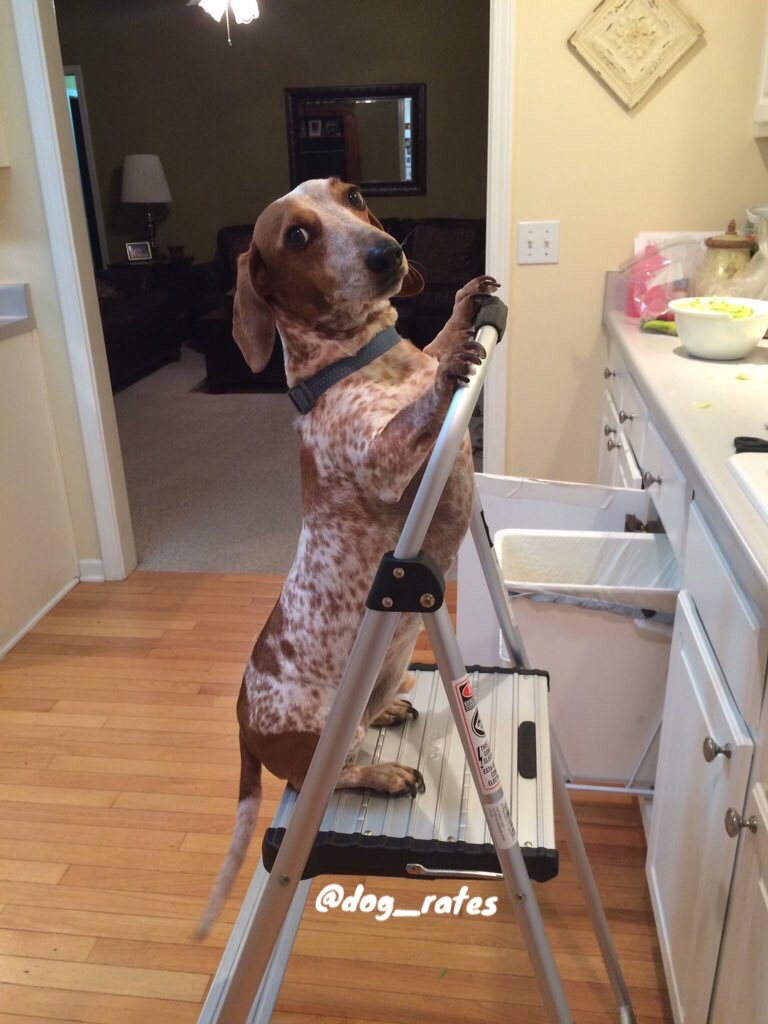

row: 1378 --> This is Yoda. He's a Zimbabwean Rutabaga. Freaks out if u stop scratching his belly. Incredibly self-centered. 9/10 https://t.co/yVdMsVYHIx


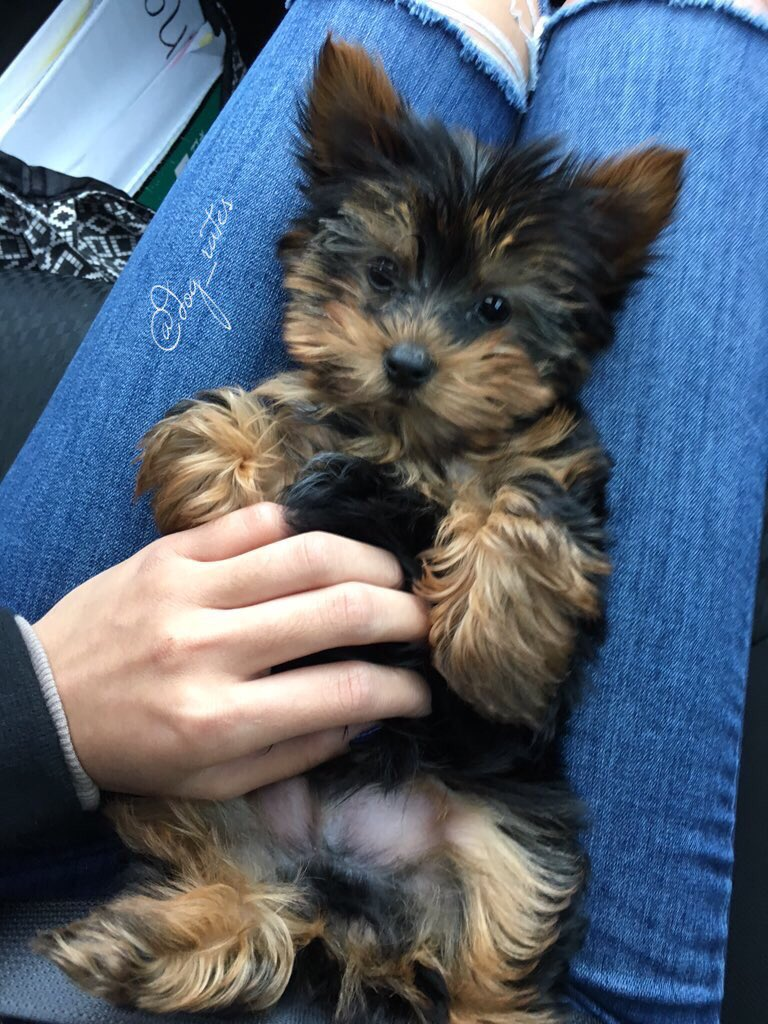

row: 485 --> RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/… 
 No Image to display


In [35]:
# The fun of this site is on numerators above 10. Let's get a sample to see how they look like in the text
for i in df_werated.query("rating_numerator < 10").sample(5).index:
    try:
        id = df_werated.tweet_id[i]
        url = df_img_pred.query("tweet_id == @id").jpg_url.values[0]
        print(f"row: {i}", "-->", df_werated.text[i])
        display(Image(url, width=150, height=150))
    except:
        print(f"row: {i}", "-->", df_werated.text[i], "\n", "No Image to display")

In [36]:
# Checking for suspicious names
df_werated.name.value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Toby         7
an           7
Bailey       7
Leo          6
Oscar        6
Name: name, dtype: int64

> Here is just a guess... I believe that all the correct names are written with the first letter `capitalized` and the incorrect ones start in `lower case`

In [37]:
set(df_werated[~df_werated.name.str[0].str.isupper()].name)

{'a',
 'actually',
 'all',
 'an',
 'by',
 'getting',
 'his',
 'incredibly',
 'infuriating',
 'just',
 'life',
 'light',
 'mad',
 'my',
 'not',
 'officially',
 'old',
 'one',
 'quite',
 'space',
 'such',
 'the',
 'this',
 'unacceptable',
 'very'}

> Apparently, a good hint. Will use this assumption to discard these names.

In [38]:
# Checking the column source
for e in df_werated.source.sample(3):
    print(e)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>


> This column contains three elements: url, rel (which I assume that is if the person is a follower or not) and the source of the tweet. From the Tidness point of view, this is not OK.

In [39]:
df_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [40]:
df_img_pred.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [41]:
df_img_pred.p1.value_counts().head(20)

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
Name: p1, dtype: int64

In [42]:
df_img_pred.p2.value_counts().head(20)

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
Pembroke                           27
Eskimo_dog                         27
collie                             27
kuvasz                             26
Italian_greyhound                  22
American_Staffordshire_terrier     21
Pekinese                           21
chow                               20
Name: p2, dtype: int64

In [43]:
df_img_pred.p3.value_counts().head(20)

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
Staffordshire_bullterrier         32
chow                              32
beagle                            31
cocker_spaniel                    31
Pomeranian                        29
toy_poodle                        29
Pekinese                          29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
pug                               23
Name: p3, dtype: int64

In [44]:
df_img_pred.tweet_id.duplicated().sum()

0

In [45]:
df_tweet_details.head()

tweet_id  retweet_count  favorite_count  followers_count  \
0  892420643555336193           8853           39467          3200889   
1  892177421306343426           6514           33819          3200889   
2  891815181378084864           4328           25461          3200889   
3  891689557279858688           8964           42908          3200889   
4  891327558926688256           9774           41048          3200889   

   friends_count                                             source  \
0            104  <a href="http://twitter.com/download/iphone" r...   
1            104  <a href="http://twitter.com/download/iphone" r...   
2            104  <a href="http://twitter.com/download/iphone" r...   
3            104  <a href="http://twitter.com/download/iphone" r...   
4            104  <a href="http://twitter.com/download/iphone" r...   

  retweeted_status  
0   Original Tweet  
1   Original Tweet  
2   Original Tweet  
3   Original Tweet  
4   Original Tweet

In [46]:
df_tweet_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   int64 
 1   retweet_count     2354 non-null   int64 
 2   favorite_count    2354 non-null   int64 
 3   followers_count   2354 non-null   int64 
 4   friends_count     2354 non-null   int64 
 5   source            2354 non-null   object
 6   retweeted_status  2354 non-null   object
dtypes: int64(5), object(2)
memory usage: 128.9+ KB


In [47]:
df_tweet_details.describe()

tweet_id  retweet_count  favorite_count  followers_count  \
count  2.354000e+03    2354.000000     2354.000000     2.354000e+03   
mean   7.426978e+17    3164.797366     8080.968564     3.200942e+06   
std    6.852812e+16    5284.770364    11814.771334     4.457302e+01   
min    6.660209e+17       0.000000        0.000000     3.200799e+06   
25%    6.783975e+17     624.500000     1415.000000     3.200898e+06   
50%    7.194596e+17    1473.500000     3603.500000     3.200945e+06   
75%    7.993058e+17    3652.000000    10122.250000     3.200953e+06   
max    8.924206e+17   79515.000000   132810.000000     3.201018e+06   

       friends_count  
count         2354.0  
mean           104.0  
std              0.0  
min            104.0  
25%            104.0  
50%            104.0  
75%            104.0  
max            104.0

In [48]:
df_tweet_details.tweet_id.duplicated().sum()

0

## Quality issues

### Due to Completeness

1. `df_werated`: There are some rows which are missing data in the column `expanded_urls`. Possibly this was an issue during the data extraction or these tweets are not from a picture rating. In the last case, these rows should be removed


### Due to Validity

1. `df_werated`: `name` incorrect or typo
2. `all tables`: `tweet_id` shown as as int when should be as str
3. `df_werated`: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` should be in string format
4. Not all tweets are original. The columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` should have only `NULL` values
5. `df_img_pred`: Some predictions are of other animals/objects than a dog, such as turtle or starfish


### Due to Accurrancy

1. `df_werated`: `rating_numerator` with decimal values. Replace by its correct value.
2. `df_werated`: `timestamp` should be set as date and time
3. df_werated: Correct the ratings of the tweets according as described in `df_tweets_to_correct`


### Due to Consistency

1. `df_img_pred`: `p1`, `p2` and `p3` not following a case logic: sometimes title case, sometimes lower case. It should be all Title case and removing the `_` between names
2. `df_werated`: `rating_denominator` with strange values (outlier values). It was supposed to be 10

## Tidiness issues
1. `df_werated`: the column `source` showing in html tags. It should be diveded by `url_ref`, `rel` and `tweet_source`
2. `df_werated`: Columns `doggo`, `floofer`, `pupper`, `puppo` should be turn into a single column called `dog_stage`
3. `df_werated`: Some columns will become unnecessary for analysis, so we should identify them and discard.
4. `df_tweet_details` should be merged to `df_werated` for graphical analysis

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [49]:
df_werated_clean = df_werated.copy()
df_img_pred_clean = df_img_pred.copy()
df_tweet_details_clean = df_tweet_details.copy()

## Due to Quality Issues

### Issue #1: Correcting data types

####  Define: 
a. Change `tweet_id` data type as `str` in all the tables<br>
b. In the table `df_werated`: change the data type of the columns`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` to str<br>
c. change `timestamp` datatype to date and time

#### Code

In [50]:
# Dealing with string columns
df_werated_clean["tweet_id"] = df_werated_clean["tweet_id"].astype(str)
df_img_pred_clean["tweet_id"] = df_img_pred_clean["tweet_id"].astype(str)
df_tweet_details_clean["tweet_id"] = df_tweet_details_clean["tweet_id"].astype(str)

In [51]:
df_werated_clean = df_werated_clean.fillna(
    value={
        "in_reply_to_status_id": 0.0,
        "in_reply_to_user_id": 0.0,
        "retweeted_status_id": 0.0,
        "retweeted_status_user_id": 0.0,
    },
    method=None,
)

In [52]:
df_werated_clean = df_werated_clean.astype(
    {
        "in_reply_to_status_id": "int64",
        "in_reply_to_user_id": "int64",
        "retweeted_status_id": "int64",
        "retweeted_status_user_id": "int64",
    }
)

In [53]:
df_werated_clean = df_werated_clean.astype(
    {
        "in_reply_to_status_id": "str",
        "in_reply_to_user_id": "str",
        "retweeted_status_id": "str",
        "retweeted_status_user_id": "str",
    }
)

In [54]:
cols = [
    "in_reply_to_status_id",
    "in_reply_to_user_id",
    "retweeted_status_id",
    "retweeted_status_user_id",
]
for c in cols:
    df_werated_clean[c] = df_werated_clean[c].replace({"0": np.NaN})

In [55]:
# Dealing with date and time columns
df_werated_clean["timestamp"] = pd.to_datetime(
    df_werated_clean["timestamp"]
).dt.tz_convert(None)

#### Test

In [56]:
df_werated_clean.dtypes

tweet_id                              object
in_reply_to_status_id                 object
in_reply_to_user_id                   object
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                   object
retweeted_status_user_id              object
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

In [57]:
df_img_pred_clean.tweet_id.dtypes

dtype('O')

In [58]:
df_tweet_details_clean.tweet_id.dtypes

dtype('O')

### Issue #2: Retweets in the dataset

#### Define
Discard Retweets

#### Code

> We only want original tweets here. Therefore, the column `retweet_status_id` should only have null values

In [59]:
df_werated_clean = df_werated_clean[df_werated_clean.retweeted_status_id.isnull()]

In [60]:
df_tweet_details_clean = df_tweet_details_clean.query(
    "retweeted_status == 'Original Tweet'"
)

#### Test

In [61]:
df_werated_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   object        
 1   in_reply_to_status_id       78 non-null     object        
 2   in_reply_to_user_id         78 non-null     object        
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      object        
 7   retweeted_status_user_id    0 non-null      object        
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2175 non-null   int64         
 11  rating_denominator          2175 non-null   int64       

In [62]:
df_tweet_details_clean.retweeted_status.value_counts()

Original Tweet    2175
Name: retweeted_status, dtype: int64

### Issue #3a: rows missing expanded urls

#### Define
Check the missing data rows and clean the records that do not correspond to an image rating, if that is the case

#### Code

In [63]:
df_werated_clean[df_werated_clean["expanded_urls"].isnull()]

tweet_id in_reply_to_status_id in_reply_to_user_id  \
30    886267009285017600    886266357075128320          2281181600   
55    881633300179243008    881607037314052096            47384430   
64    879674319642796034    879553827334172672          3105440746   
113   870726314365509632    870726202742493184            16487760   
148   863427515083354112    863425645568774144            77596200   
179   857214891891077121    857156678055342080           180670967   
186   856288084350160898    856286004109553664           279280991   
188   855862651834028034    855861584463351808           194351775   
189   855860136149123072    855858535607001088            13615722   
218   850333567704068097    850328818778820608            21955058   
228   848213670039564288    848212111729840128          4196983835   
234   847617282490613760    847606175596138496          4196983835   
274   840698636975636481    840698300298862592  840547864354918400   
290   838150277551247360    838145498691194880            21955058   
291   838085839343206401    838085539362402304          2894131180   
313   835246439529840640    835245984028504064            26259576   
342   832088576586297345    832087547559997440            30582082   
346   831926988323639298    831903044224835584            20683724   
375   828361771580813312                   NaN                 NaN   
387   826598799820865537    826598365270007808          4196983835   
409   823333489516937216    823326389336244224          1582853809   
427   821153421864615936    821152592717697024           113211856   
498   813130366689148928    813127251579564032          4196983835   
513   811647686436880384    811627233043480576          4196983835   
570   801854953262350336    801854330672447488            11856342   
576   800859414831898624    800857954417262592           291859009   
611   797165961484890113    797123751162839040            29166305   
701   786051337297522688    772743019447607296  730505014150582272   
707   785515384317313025                   NaN                 NaN   
843   766714921925144576    766711819364888576          4196983835   
857   763956972077010945    763865174553964544            15846407   
967   750381685133418496    750180498832404480          4717297476   
1005  747651430853525504    747648653817413632          4196983835   
1080  738891149612572673    738411919896285184           358972768   
1295  707983188426153984    707980065892667392          2319108198   
1345  704491224099647488    704485744639909888            28785486   
1445  696518437233913856                   NaN                 NaN   
1446  696490539101908992    696488710901260288          4196983835   
1474  693644216740769793    693642232151285760          4196983835   
1479  693582294167244802    693572215938367488          1198988510   
1497  692423280028966913    692417313023332352          4196983835   
1523  690607260360429569    690341253549002752           467036706   
1598  686035780142297088    686034024800862208          4196983835   
1605  685681090388975616    685547936038666240          4196983835   
1618  684969860808454144    684959798585110528          4196983835   
1663  682808988178739200    682788441537560576          4196983835   
1689  681340665377193984    681339448655802368          4196983835   
1774  678023323247357953    678021115718029312          4196983835   
1819  676590572941893632    676588346097852416          4196983835   
1844  675849018447167488    675845657354215424          4196983835   
1895  674742531037511680    674739953134403584          4196983835   
1905  674606911342424069    674468880899788800          4196983835   
1914  674330906434379776    665814696700723200            16374678   
1940  673716320723169284    673715861853720576          4196983835   
2038  671550332464455680    671544874165002240          4196983835   
2149  669684865554620416    669354382627049472          4196983835   
2189  668967877119254528  

In [64]:
df_werated_clean[df_werated_clean["expanded_urls"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 30 to 2298
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    58 non-null     object        
 1   in_reply_to_status_id       55 non-null     object        
 2   in_reply_to_user_id         55 non-null     object        
 3   timestamp                   58 non-null     datetime64[ns]
 4   source                      58 non-null     object        
 5   text                        58 non-null     object        
 6   retweeted_status_id         0 non-null      object        
 7   retweeted_status_user_id    0 non-null      object        
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               0 non-null      object        
 10  rating_numerator            58 non-null     int64         
 11  rating_denominator          58 non-null     int64        

> One thing is interesting about these records: Most of them are marked as `in_reply_to_status_id` while the big majority of the original tweets don't have this field filled in. This can be an indication that, if this field is not empty, the tweet is not valid as a original tweet. Let's check the text to confirm if we should keep these records:

In [65]:
df_miss_expanded_url = (
    df_werated_clean[df_werated_clean["expanded_urls"].isnull()]
    .copy()
    .reset_index(drop=True)
)

In [66]:
for i in df_miss_expanded_url.index:
    print(df_miss_expanded_url.tweet_id[i], "-->", df_miss_expanded_url.text[i])

886267009285017600 --> @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
881633300179243008 --> @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
879674319642796034 --> @RealKentMurphy 14/10 confirmed
870726314365509632 --> @ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
863427515083354112 --> @Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10
857214891891077121 --> @Marc_IRL pixelated af 12/10
856288084350160898 --> @xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10
855862651834028034 --> @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
855860136149123072 --> @s8n You tried very hard to portray this good boy as not so good, but you have ultima

In [67]:
# Checking if there is an actual prediction for these tweets:
df_img_pred_clean[df_img_pred_clean.tweet_id.isin(list(df_miss_expanded_url.tweet_id))]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

> As noticed above, the texts do not correspond to an actual rating and there is no prediction for these records.<br>
> Therefore, these records will be discarded.

In [68]:
df_werated_clean = df_werated_clean.query("expanded_urls == expanded_urls")

#### Test

In [69]:
df_werated_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2117 non-null   object        
 1   in_reply_to_status_id       23 non-null     object        
 2   in_reply_to_user_id         23 non-null     object        
 3   timestamp                   2117 non-null   datetime64[ns]
 4   source                      2117 non-null   object        
 5   text                        2117 non-null   object        
 6   retweeted_status_id         0 non-null      object        
 7   retweeted_status_user_id    0 non-null      object        
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2117 non-null   int64         
 11  rating_denominator          2117 non-null   int64       

> There are still some records with `reply_status_id` filled in, but these records do have an url. Let's check how they look like:

### Issue #3b: Handle the remaining rows with missing expanded urls

#### Define
Check the missing data rows and clean the records that do not correspond to an image rating, if that is the case

#### Code

In [70]:
df_img_pred_clean[
    df_img_pred_clean.tweet_id.isin(
        list(
            df_werated_clean[
                ~df_werated_clean["in_reply_to_status_id"].isnull()
            ].tweet_id
        )
    )
].shape

(23, 12)

In [71]:
df_werated_clean[
    ~df_werated_clean["in_reply_to_status_id"].isnull()
].in_reply_to_user_id.value_counts()

4196983835    23
Name: in_reply_to_user_id, dtype: int64

> All the records are related to a photo prediction, therefore, valid records. Curiously, it is replying the same user id. 
Checking this user ID in twitterWhich turns out to be `@dog_rates`.<br>
> Therefore, we keep these records.

#### Test

In [72]:
# Prooving that the texts are of an image rating
df_rep_tweet = df_werated_clean[~df_werated_clean["in_reply_to_user_id"].isnull()]
for i in df_rep_tweet.index:
    print(df_rep_tweet.tweet_id[i], "-->", df_rep_tweet.text[i])

863079547188785154 --> Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen
856526610513747968 --> THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA
844979544864018432 --> PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B
802265048156610565 --> Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
746906459439529985 --> PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
746818907684614144 --> Guys... Dog Jesus 2.0
13/10 buoyant af https://t.co/CuNA7OwfKQ
729838605770891264 --> "Challenge completed" 
(pupgraded to 12/10) https://t.co/85dTK7XCXB
705786532653883392 --> Seriously, add us 🐶 11/10 for sad wet pupper https://t

### Issue #4: Strange Names and Typos

#### Define
Replace dog names that do not start with Capital Letter in `df_werated_clean`

#### Code

In [73]:
df_werated_clean.name = df_werated_clean.name.str.replace("^[a-z]+", "None")

C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


#### Test

In [74]:
df_werated_clean.name.value_counts().head(20)

None       726
Lucy        11
Charlie     11
Cooper      10
Oliver      10
Tucker       9
Penny        9
Winston      8
Lola         8
Sadie        8
Daisy        7
Toby         7
Stanley      6
Koda         6
Oscar        6
Jax          6
Bella        6
Bailey       6
Bo           6
Rusty        5
Name: name, dtype: int64

In [75]:
df_werated_clean.name.sample(10)

1198         Link
426      Sundance
1907         None
1048         Kilo
1676         None
651       Monster
226          None
2047    Scruffers
261       Charlie
1233      Stubert
Name: name, dtype: object

### Issue #5: Incorrect ratings

#### Define
Replace the `rating_numerator` and `rating_denominator`  in `df_werated_clean` for the tweets in `df_tweets_to_correct`

#### Code

In [76]:
df_tweets_to_correct

tweet_id  new_numerator  new_denominator
0  775096608509886464             14               10
1  716439118184652801             11               10
2  682962037429899265             10               10

In [77]:
for i, tweet in enumerate(df_tweets_to_correct.tweet_id):

    r = df_werated_clean.query("tweet_id == @tweet")
    if len(r) > 0:
        df_werated_clean["rating_numerator"][r.index] = df_tweets_to_correct[
            "new_numerator"
        ][i]
        df_werated_clean["rating_denominator"][r.index] = df_tweets_to_correct[
            "new_denominator"
        ][i]

C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [78]:
df_werated_clean = df_werated_clean.reset_index(drop=True)

#### Test

In [79]:
df_werated_clean[df_werated_clean["tweet_id"].isin(df_tweets_to_correct["tweet_id"])][
    ["tweet_id", "rating_numerator", "rating_denominator"]
]

tweet_id  rating_numerator  rating_denominator
990   716439118184652801                11                  10
1438  682962037429899265                10                  10

### Issue #6: Correct ratings (numerator and denominator)

#### Define
Replace the `rating_numerator` in `df_werated_clean` to its decimal value from the original text

#### Code

In [80]:
# First, we need to change the data type of these fields
df_werated_clean["rating_numerator"] = df_werated_clean["rating_numerator"].astype(
    float
)

In [81]:
df_werated_clean["rating_denominator"] = df_werated_clean["rating_denominator"].astype(
    float
)

In [82]:
df_werated_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2117 non-null   object        
 1   in_reply_to_status_id       23 non-null     object        
 2   in_reply_to_user_id         23 non-null     object        
 3   timestamp                   2117 non-null   datetime64[ns]
 4   source                      2117 non-null   object        
 5   text                        2117 non-null   object        
 6   retweeted_status_id         0 non-null      object        
 7   retweeted_status_user_id    0 non-null      object        
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2117 non-null   float64       
 11  rating_denominator          2117 non-null   float64     

In [83]:
df_werated_clean.reset_index(drop=True, inplace=True)

In [84]:
dic_ratings = {"text": [], "index": [], "value": []}

In [85]:
for i, t in enumerate(df_werated_clean["text"]):
    if re.search("\d+\.\d+\/\d+", t):
        dic_ratings["text"].append(t)
        dic_ratings["index"].append(i)
        dic_ratings["value"].append(re.search("\d+\.\d+", t).group())

In [86]:
for i, v in enumerate(dic_ratings["index"]):
    df_werated_clean["rating_numerator"][v] = dic_ratings["value"][i]

C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
for t in df_werated_clean.query("rating_numerator>= rating_numerator.std()")["text"]:
    print(t)

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Tha

> What I noticed is that most of these **exagerated** numerators are succeeded by an also **exagerated** denominator. Therefore, for a better comparison, an additional column called `rating` will be created by the result of the division between `numerator` and `denominator`

In [88]:
df_werated_clean["rating"] = (
    df_werated_clean["rating_numerator"] / df_werated_clean["rating_denominator"]
)

#### Test

In [89]:
for i in dic_ratings["index"]:
    print(
        df_werated_clean["rating_numerator"][i],
        "-->",
        df_werated_clean["text"][i][
            : re.search("\d+\.\d+", df_werated_clean["text"][i]).end() + 1
        ],
    )

13.5 --> This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/
9.75 --> This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/
11.27 --> This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/
11.26 --> Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/


In [90]:
df_werated_clean[
    ["tweet_id", "rating_numerator", "rating_denominator", "rating"]
].sample(20)

tweet_id  rating_numerator  rating_denominator  rating
421   807106840509214720              13.0                10.0     1.3
1745  672984142909456390               9.0                10.0     0.9
1530  678767140346941444               8.0                10.0     0.8
1817  671488513339211776               8.0                10.0     0.8
8     890609185150312448              13.0                10.0     1.3
1861  670764103623966721              10.0                10.0     1.0
77    875144289856114688              13.0                10.0     1.3
1324  689289219123089408              13.0                10.0     1.3
1142  703407252292673536              10.0                10.0     1.0
439   802952499103731712              12.0                10.0     1.2
513   789903600034189313              13.0                10.0     1.3
1815  671504605491109889              11.0                10.0     1.1
1572  677187300187611136               9.0                10.0     0.9
1125  704871453724954624              12.0                10.0     1.2
38    884247878851493888              13.0                10.0     1.3
1264  693262851218264065              11.0                10.0     1.1
1712  673707060090052608              10.0                10.0     1.0
1480  680805554198020098               9.0                10.0     0.9
940   725786712245440512              11.0                10.0     1.1
636   770069151037685760              10.0                10.0     1.0

In [91]:
df_werated_clean.describe()

rating_numerator  rating_denominator       rating
count       2117.000000         2117.000000  2117.000000
mean          12.187898           10.481814     1.165293
std           40.241013            7.053755     3.944543
min            0.000000            2.000000     0.000000
25%           10.000000           10.000000     1.000000
50%           11.000000           10.000000     1.100000
75%           12.000000           10.000000     1.200000
max         1776.000000          170.000000   177.600000

### Issue #7: Standardize dog breeds

#### Define
Replace `_` by space and set the string case as Title

#### Code

In [92]:
# Number of unique breeds before
bb1 = df_img_pred_clean.p1.unique()
bb2 = df_img_pred_clean.p2.unique()
bb3 = df_img_pred_clean.p3.unique()

In [93]:
df_img_pred_clean[["p1", "p2", "p3"]] = df_img_pred_clean[["p1", "p2", "p3"]].replace(
    "_", " ", regex=True
)
df_img_pred_clean[["p1", "p2", "p3"]] = df_img_pred_clean[["p1", "p2", "p3"]].apply(
    lambda col: col.str.title()
)

In [94]:
ba1 = df_img_pred_clean.p1.unique()
ba2 = df_img_pred_clean.p2.unique()
ba3 = df_img_pred_clean.p3.unique()

#### Test

In [95]:
print(
    " p1 changed:",
    len(bb1) != len(ba1),
    "\n",
    "p2 changed:",
    len(bb2) != len(ba2),
    "\n",
    "p3 changed:",
    len(bb1) != len(ba1),
)

 p1 changed: False 
 p2 changed: True 
 p3 changed: False


In [96]:
df_img_pred_clean[["p1", "p2", "p3"]].sample(5)

p1                  p2                              p3
1722       Acorn Squash         Toilet Seat                      Toy Poodle
65           Toy Poodle           Chihuahua                        Bluetick
250   Shetland Sheepdog        Home Theater  American Staffordshire Terrier
1954   Golden Retriever  Labrador Retriever                 Tibetan Mastiff
915           Chihuahua            Pembroke                         Basenji

### Issue #8: Identify the predicted breed

#### Define
Create a field that identifies the predicted dog breed followed by the confidence level

#### Code

In [97]:
df_img_pred_clean["pred_dog_breed"] = None
df_img_pred_clean["pred_conf"] = np.NaN

In [98]:
for i, row in df_img_pred_clean.iterrows():
    if row.p1_dog:
        df_img_pred_clean["pred_dog_breed"][i] = row.p1
        df_img_pred_clean["pred_conf"][i] = row.p1_conf
    elif row.p2_dog:
        df_img_pred_clean["pred_dog_breed"][i] = row.p2
        df_img_pred_clean["pred_conf"][i] = row.p2_conf
    elif row.p3_dog:
        df_img_pred_clean["pred_dog_breed"][i] = row.p3
        df_img_pred_clean["pred_conf"][i] = row.p3_conf
    else:
        df_img_pred_clean["pred_dog_breed"][i] = "Not a Dog"
        df_img_pred_clean["pred_conf"][i] = np.NaN

C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\iurkl\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

#### Test

In [99]:
df_img_pred_clean.sample(10)

tweet_id                                          jpg_url  \
418   674036086168010753  https://pbs.twimg.com/media/CVqoPslWEAEk7EC.jpg   
909   700518061187723268  https://pbs.twimg.com/media/Cbi9dI_UYAAgkyC.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
2034  883838122936631299  https://pbs.twimg.com/media/DEQGFgAXUAAEvfi.jpg   
21    666293911632134144  https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
596   679527802031484928  https://pbs.twimg.com/media/CW4q7jDWkAA2y8g.jpg   
1280  750132105863102464  https://pbs.twimg.com/media/CmkBKuwWgAAamOI.jpg   
31    666421158376562688  https://pbs.twimg.com/media/CT-aggCXAAIMfT3.jpg   
123   668226093875376128  https://pbs.twimg.com/media/CUYEFlQXAAUkPGm.jpg   
977   707038192327901184  https://pbs.twimg.com/media/Cc_ney1W4AANuY3.jpg   

      img_num                              p1   p1_conf  p1_dog  \
418         1                      Toy Poodle  0.685617    True   
909         1  American Staffordshire Terrier  0.569501    True   
2           1                 German Shepherd  0.596461    True   
2034        1                        Doberman  0.610946    True   
21          1                Three-Toed Sloth  0.914671   False   
596         1                         Mailbox  0.336393   False   
1280        1                      Toy Poodle  0.478018    True   
31          1                Blenheim Spaniel  0.906777    True   
123         1                        Trombone  0.390339   False   
977         1                             Pug  0.642426    True   

                             p2   p2_conf  p2_dog              p3   p3_conf  \
418            Miniature Poodle  0.151936    True     Maltese Dog  0.045531   
909   Staffordshire Bullterrier  0.211308    True       Chihuahua  0.121839   
2                      Malinois  0.138584    True      Bloodhound  0.116197   
2034         Miniature Pinscher  0.299603    True          Kelpie  0.063020   
21                        Otter  0.015250   False  Great Grey Owl  0.013207   
596                      Cannon  0.158936   False         Cuirass  0.052647   
1280           Miniature Poodle  0.207458    True    Croquet Ball  0.085879   
31               Cocker Spaniel  0.090346    True        Shih-Tzu  0.001117   
123                      Cornet  0.314149   False     French Horn  0.255182   
977                       Llama  0.057306   False  French Bulldog  0.054186   

      p3_dog                  pred_dog_breed  pred_conf  
418     True                      Toy Poodle   0.685617  
909     True  American Staffordshire Terrier   0.569501  
2       True                 German Shepherd   0.596461  
2034    True                        Doberman   0.610946  
21     False                       Not a Dog        NaN  
596    False                       Not a Dog        NaN  
1280   False                      Toy Poodle   0.478018  
31      True                Blenheim Spaniel   0.906777  
123    False                       Not a Dog        NaN  
977     True                             Pug   0.642426

In [100]:
df_img_pred_clean.pred_dog_breed.value_counts()

Not a Dog               324
Golden Retriever        173
Labrador Retriever      113
Pembroke                 96
Chihuahua                95
                       ... 
Scotch Terrier            1
Entlebucher               1
Japanese Spaniel          1
Standard Schnauzer        1
Bouvier Des Flandres      1
Name: pred_dog_breed, Length: 114, dtype: int64

In [101]:
df_img_pred_clean.query("pred_dog_breed == 'Not a Dog'").sample(10)

tweet_id                                          jpg_url  \
2046  886680336477933568  https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
232   670417414769758208  https://pbs.twimg.com/media/CU3NE8EWUAEVdPD.jpg   
112   667911425562669056  https://pbs.twimg.com/media/CUTl5m1WUAAabZG.jpg   
1057  714631576617938945  https://pbs.twimg.com/media/CerhoBWWAAA5eLL.jpg   
929   702932127499816960  https://pbs.twimg.com/media/CcFRCfRW4AA5a72.jpg   
512   676215927814406144  https://pbs.twimg.com/media/CWJmzNsWUAE706Z.jpg   
840   694669722378485760  https://pbs.twimg.com/media/CaP2bS8WYAAsMdx.jpg   
366   672902681409806336  https://pbs.twimg.com/media/CVahaz9XAAA8uTy.jpg   
446   674664755118911488  https://pbs.twimg.com/media/CVzkA7-WsAAcXz6.jpg   
1755  824796380199809024  https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg   

      img_num                 p1   p1_conf  p1_dog                  p2  \
2046        1        Convertible  0.738995   False          Sports Car   
232         1         Sea Urchin  0.493257   False           Porcupine   
112         1     Frilled Lizard  0.257695   False                  Ox   
1057        1            Meerkat  0.143497   False              Weasel   
929         1            Wallaby  0.410710   False              Wombat   
512         1            Hamster  0.999484   False          Guinea Pig   
840         2             Beaver  0.457094   False            Mongoose   
366         1                Ram  0.374466   False             Bighorn   
446         1  African Crocodile  0.330625   False  American Alligator   
1755        2           Gas Pump  0.676439   False           Harvester   

       p2_conf  p2_dog                   p3   p3_conf  p3_dog pred_dog_breed  \
2046  0.139952   False            Car Wheel  0.044173   False      Not a Dog   
232   0.460565   False              Cardoon  0.008146   False      Not a Dog   
112   0.235160   False          Triceratops  0.085317   False      Not a Dog   
1057  0.117402   False  Black-Footed Ferret  0.099933   False      Not a Dog   
929   0.239332   False               Beaver  0.149605   False      Not a Dog   
512   0.000158   False             Broccoli  0.000061   False      Not a Dog   
840   0.228298   False               Marmot  0.148309   False      Not a Dog   
366   0.159621   False        Arabian Camel  0.111919   False      Not a Dog   
446   0.075356   False                 Mink  0.057481   False      Not a Dog   
1755  0.049995   False                Swing  0.044660   False      Not a Dog   

      pred_conf  
2046        NaN  
232         NaN  
112         NaN  
1057        NaN  
929         NaN  
512         NaN  
840         NaN  
366         NaN  
446         NaN  
1755        NaN

> Just checking the predictions which a dog was not identified

p1:Ibex p2:Bighorn p3:Ram


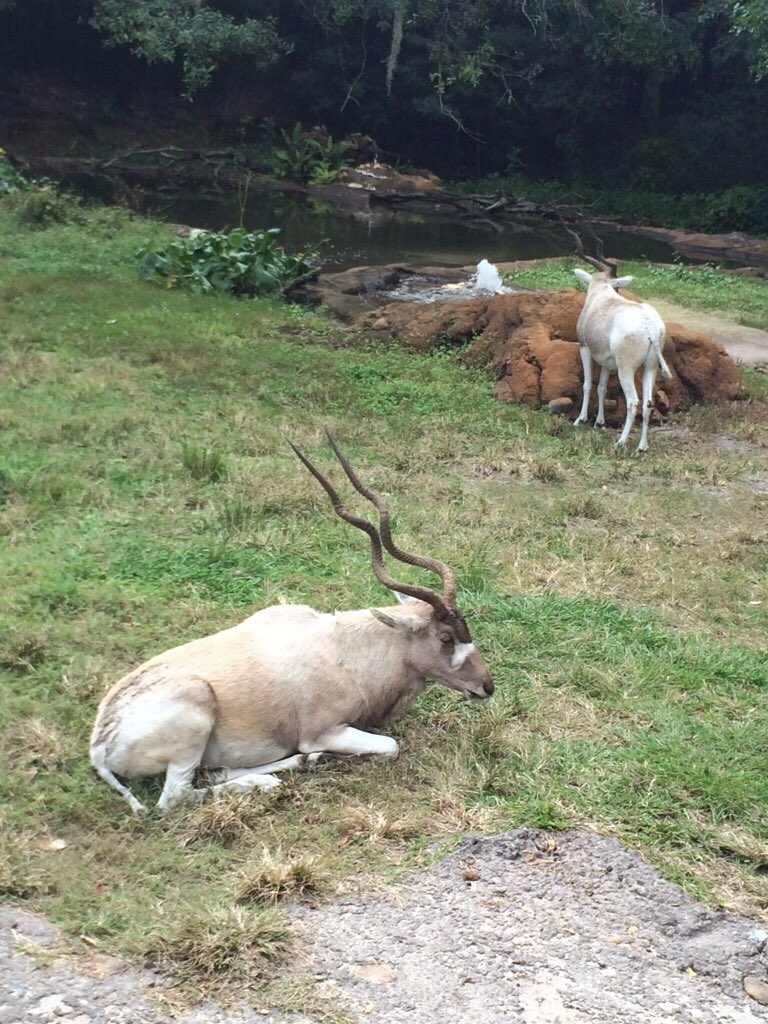

p1:Marmot p2:Meerkat p3:Weasel


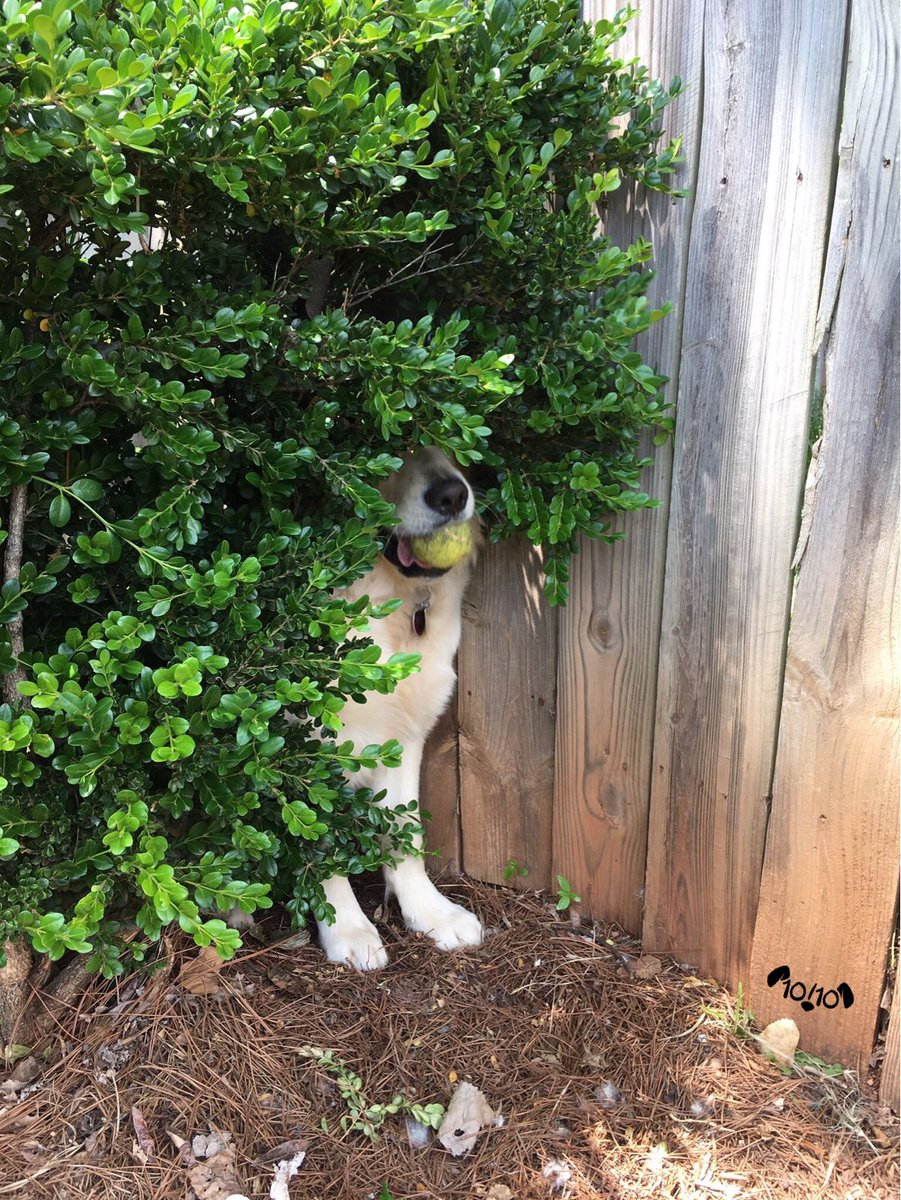

p1:Coil p2:Dugong p3:Rain Barrel


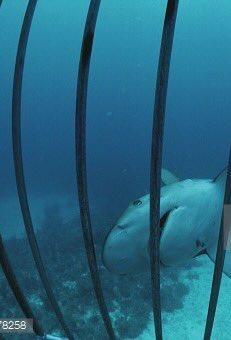

p1:Killer Whale p2:Grey Whale p3:Hammerhead


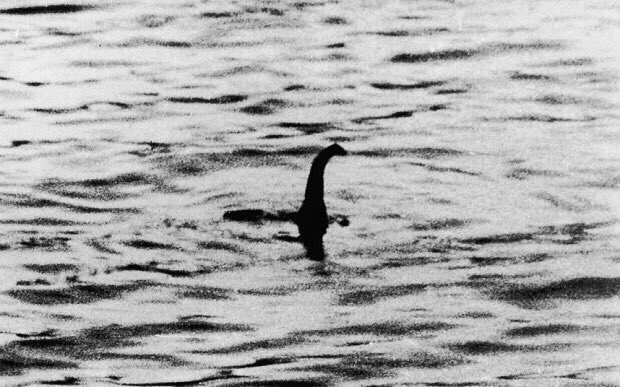

p1:Lawn Mower p2:Swing p3:Barrow


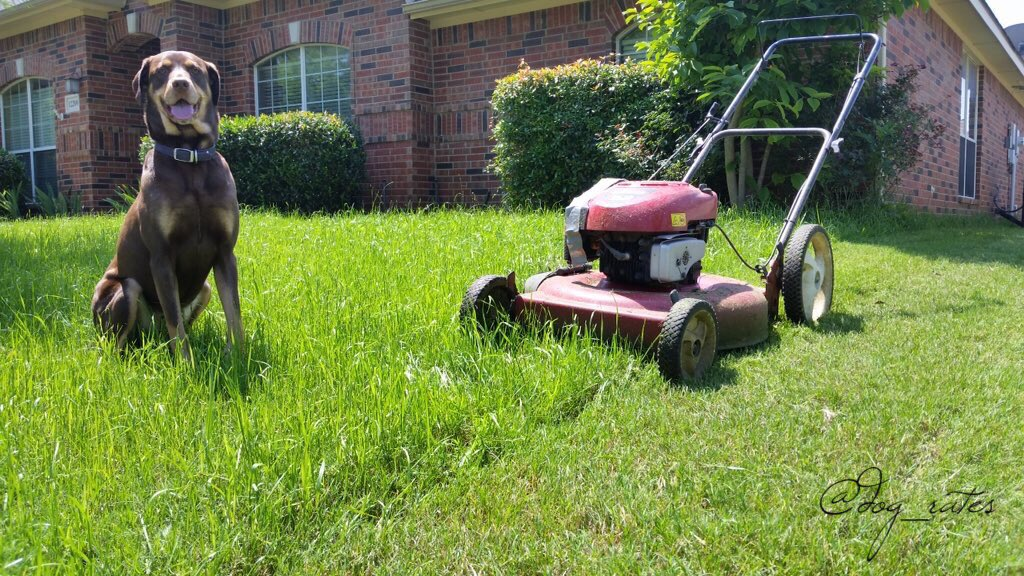

p1:Vacuum p2:Swab p3:Toilet Tissue


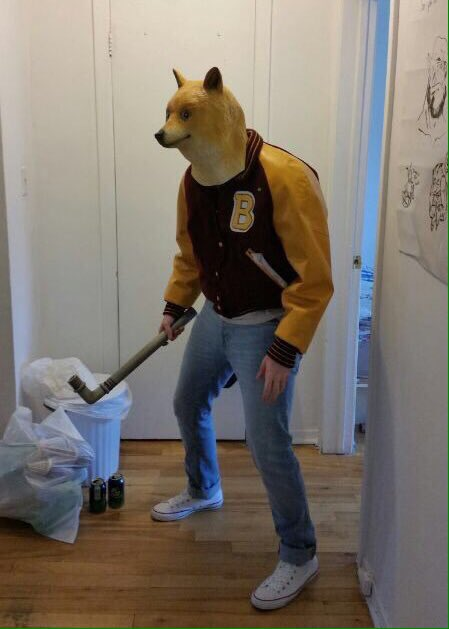

p1:Seashore p2:Promontory p3:Wreck


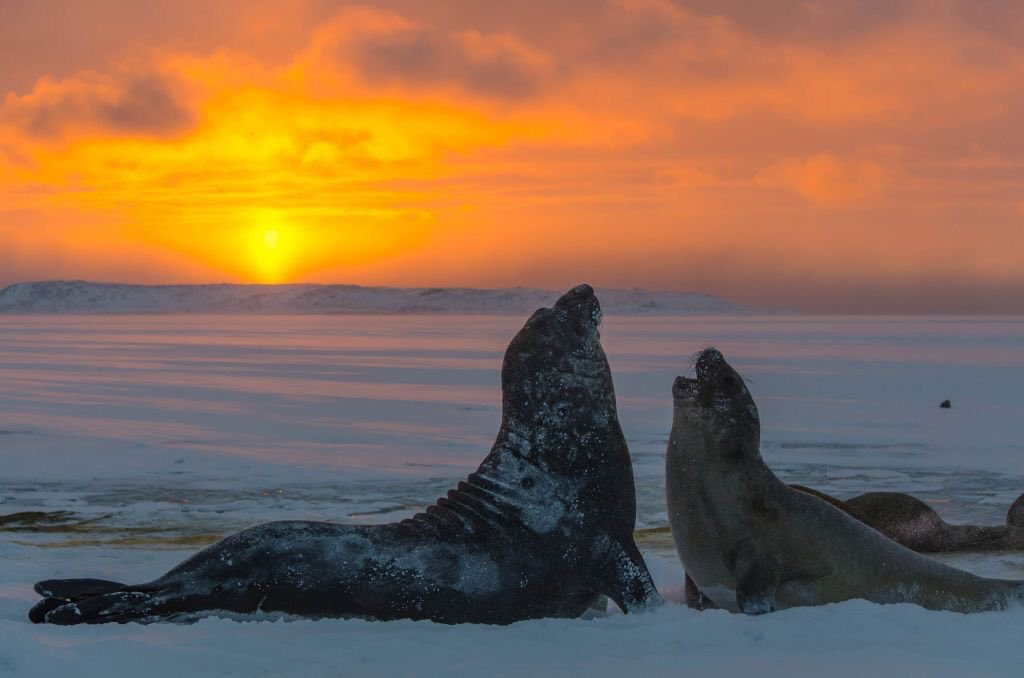

p1:Ostrich p2:Bearskin p3:Swab


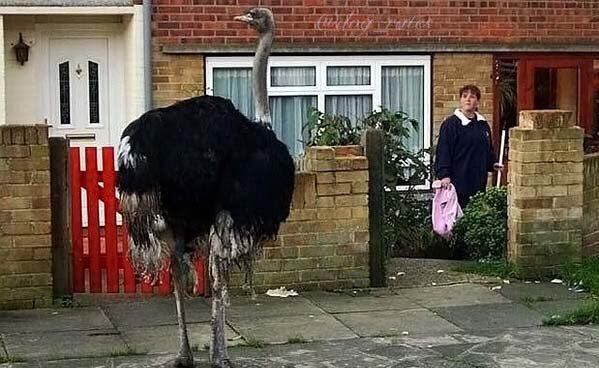

p1:Otter p2:Mink p3:Sea Lion


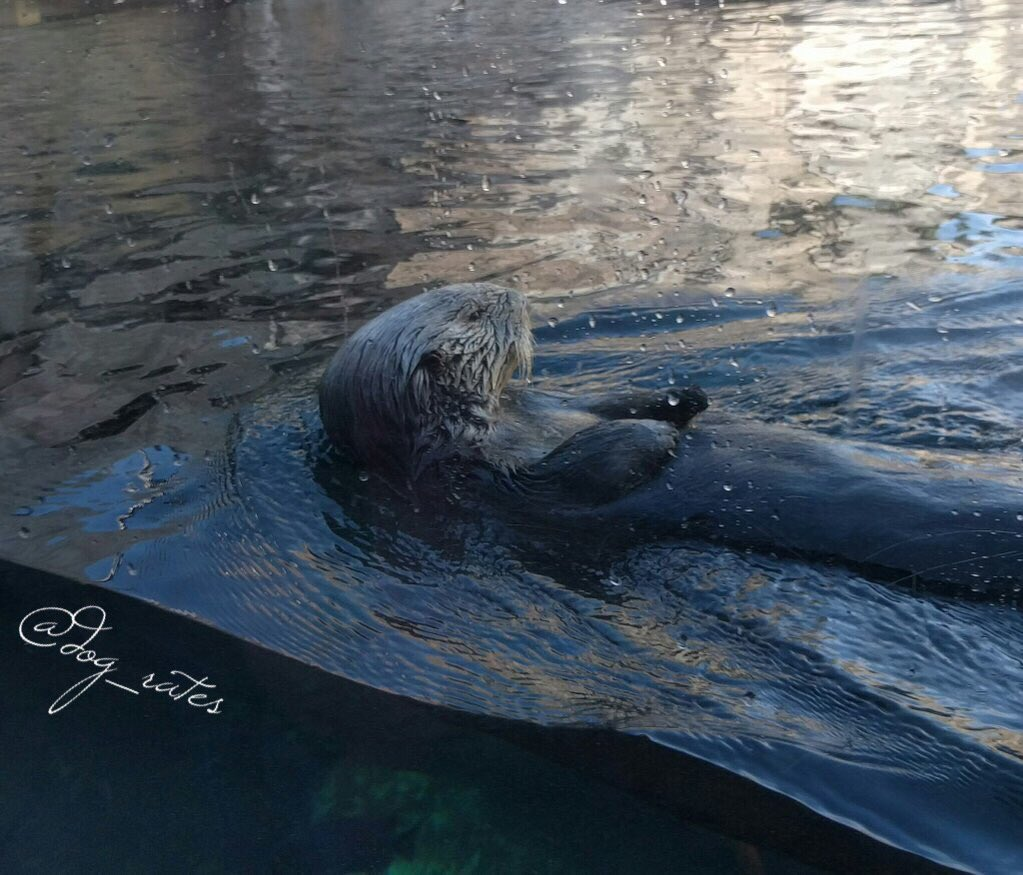

p1:Damselfly p2:Common Newt p3:Whiptail


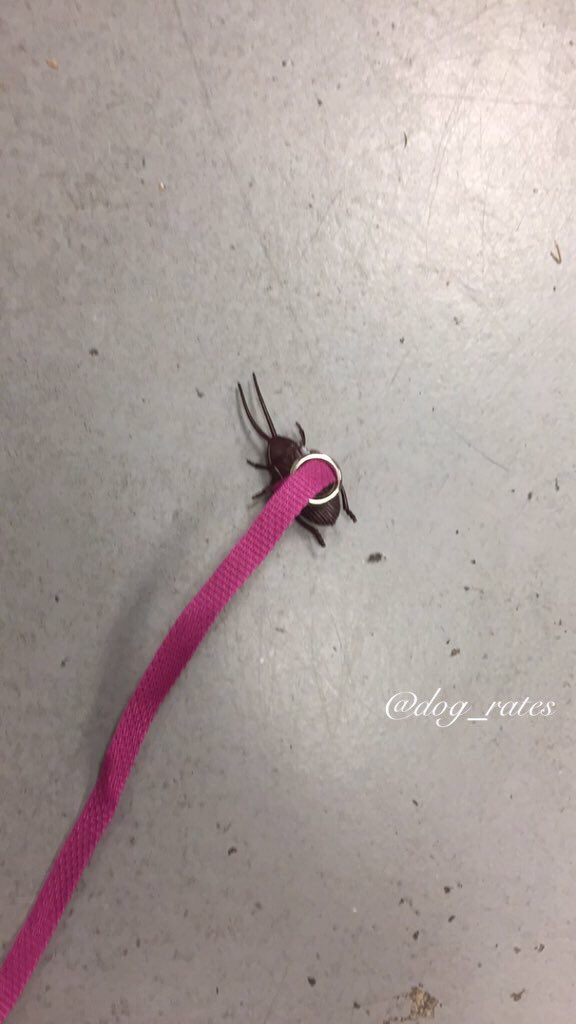

In [102]:
for i in df_img_pred_clean.query("pred_dog_breed == 'Not a Dog'").sample(10).index:
    try:

        url = df_img_pred_clean.jpg_url[i]
        print(
            f"p1:{df_img_pred_clean.p1[i]}",
            f"p2:{df_img_pred_clean.p2[i]}",
            f"p3:{df_img_pred_clean.p3[i]}",
        )
        display(Image(url, width=150, height=150))
    except:
        print(
            f"p1:{df_img_pred_clean.p1[i]}",
            f"p2:{df_img_pred_clean.p2[i]}",
            f"p3:{df_img_pred_clean.p3[i]}",
            "\n",
            "No Image to display",
        )

> Some pictures do have a dog and some not. So, some refining in the prediction model would help in the rating.

## Due to Tidness

### Issue #1: Column Source showing more than one value

#### Define
Brake the column `source` in 3 different columns: `url_ref`, `rel` and `tweet_source`

#### Code

In [103]:
# To facilitate this task, a function was created to break the colum in 3 elements:
df_werated_clean = df_werated_clean.apply(get_url_elements, axis=1)

#### Test

In [104]:
df_werated_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'rating', 'tweet_source', 'url_ref', 'rel'],
      dtype='object')

In [105]:
df_werated_clean.head()

tweet_id in_reply_to_status_id in_reply_to_user_id  \
0  892420643555336193                   NaN                 NaN   
1  892177421306343426                   NaN                 NaN   
2  891815181378084864                   NaN                 NaN   
3  891689557279858688                   NaN                 NaN   
4  891327558926688256                   NaN                 NaN   

            timestamp                                             source  \
0 2017-08-01 16:23:56  <a href="http://twitter.com/download/iphone" r...   
1 2017-08-01 00:17:27  <a href="http://twitter.com/download/iphone" r...   
2 2017-07-31 00:18:03  <a href="http://twitter.com/download/iphone" r...   
3 2017-07-30 15:58:51  <a href="http://twitter.com/download/iphone" r...   
4 2017-07-29 16:00:24  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id  retweeted_status_timestamp  \
0                       NaN                         NaN   
1                       NaN                         NaN   
2                       NaN                         NaN   
3                       NaN                         NaN   
4                       NaN                         NaN   

                                       expanded_urls  ...  rating_denominator  \
0  https://twitter.com/dog_rates/status/892420643...  ...                10.0   
1  https://twitter.com/dog_rates/status/892177421...  ...                10.0   
2  https://twitter.com/dog_rates/status/891815181...  ...                10.0   
3  https://twitter.com/dog_rates/status/891689557...  ...                10.0   
4  https://twitter.com/dog_rates/status/891327558...  ...                10.0   

       name doggo floofer pupper puppo rating        tweet_source  \
0   Phineas  None    None   None  None    1.3  Twitter for iPhone   
1     Tilly  None    None   None  None    1.3  Twitter for iPhone   
2    Archie  None    None   None  None    1.2  Twitter for iPhone   
3     Darla  None    None   None  None    1.3  Twitter for iPhone   
4  Franklin  None    None   None  None    1.2  Twitter for iPhone   

                              url_ref       rel  
0  http://twitter.com/download/iphone  nofollow  
1  http://twitter.com/download/iphone  nofollow  
2  http://twitter.com/download/iphone  nofollow  
3  http://twitter.com/download/iphone  nofollow  
4  http://twitter.com/download/iphone  nofollow  

[5 rows x 21 columns]

### Issue #2: Dog stage in one single column

#### Define
Melt the columns `doggo`, `floofer`, `pupper` and `puppo` into one single column called `dog_stage`

#### Code

In [106]:
df_werated_clean.sample(5)

tweet_id in_reply_to_status_id in_reply_to_user_id  \
1048  710153181850935296                   NaN                 NaN   
2048  667182792070062081                   NaN                 NaN   
1526  678969228704284672                   NaN                 NaN   
377   814986499976527872                   NaN                 NaN   
1875  670449342516494336                   NaN                 NaN   

               timestamp                                             source  \
1048 2016-03-16 17:18:07  <a href="http://twitter.com/download/iphone" r...   
2048 2015-11-19 03:29:07  <a href="http://twitter.com/download/iphone" r...   
1526 2015-12-21 16:04:13  <a href="http://twitter.com/download/iphone" r...   
377  2016-12-31 00:08:17  <a href="http://twitter.com/download/iphone" r...   
1875 2015-11-28 03:49:14  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
1048  This is Lacy. She's tipping her hat to you. Da...                  NaN   
2048  This is Timison. He just told an awful joke bu...                  NaN   
1526  Meet Lola. She's a Metamorphic Chartreuse. Pla...                  NaN   
377   This is Cooper. Someone attacked him with a sh...                  NaN   
1875  Vibrant dog here. Fabulous tail. Only 2 legs t...                  NaN   

      retweeted_status_user_id  retweeted_status_timestamp  \
1048                       NaN                         NaN   
2048                       NaN                         NaN   
1526                       NaN                         NaN   
377                        NaN                         NaN   
1875                       NaN                         NaN   

                                          expanded_urls  ...  \
1048  https://twitter.com/dog_rates/status/710153181...  ...   
2048  https://twitter.com/dog_rates/status/667182792...  ...   
1526  https://twitter.com/dog_rates/status/678969228...  ...   
377   https://twitter.com/dog_rates/status/814986499...  ...   
1875  https://twitter.com/dog_rates/status/670449342...  ...   

      rating_denominator     name doggo floofer  pupper puppo rating  \
1048                10.0     Lacy  None    None    None  None    1.1   
2048                10.0  Timison  None    None    None  None    1.0   
1526                10.0     Lola  None    None    None  None    1.1   
377                 10.0   Cooper  None    None  pupper  None    1.1   
1875                10.0     None  None    None    None  None    0.5   

            tweet_source                             url_ref       rel  
1048  Twitter for iPhone  http://twitter.com/download/iphone  nofollow  
2048  Twitter for iPhone  http://twitter.com/download/iphone  nofollow  
1526  Twitter for iPhone  http://twitter.com/download/iphone  nofollow  
377   Twitter for iPhone  http://twitter.com/download/iphone  nofollow  
1875  Twitter for iPhone  http://twitter.com/download/iphone  nofollow  

[5 rows x 21 columns]

In [107]:
df_werated_clean[["doggo", "floofer", "pupper", "puppo"]] = df_werated_clean[
    ["doggo", "floofer", "pupper", "puppo"]
].replace("None", "")

In [108]:
df_werated_clean["dog_class"] = df_werated_clean[
    ["doggo", "floofer", "pupper", "puppo"]
].values.tolist()
df_werated_clean["dog_class"] = df_werated_clean["dog_class"].apply(
    lambda x: " & ".join(" ".join(x).split())
)

In [109]:
df_werated_clean.dog_class.value_counts()

                   1779
pupper              222
doggo                72
puppo                23
doggo & pupper       10
floofer               9
doggo & puppo         1
doggo & floofer       1
Name: dog_class, dtype: int64

> Notice that some dogs got more than one stage class. This might be because there is more than one dog in the text description or because the tweet gave more than one description for the dog.<br> 
> Either way, according do the `Dogtionary`, a `doggo` is the most popular term. Therefore, in order to simplify the classification, the column will identify only the first recognized stage following the order: `doggo, floofer, pupper, puppo` as in the original dataframe

In [110]:
df_werated_clean["dog_stage"] = df_werated_clean["dog_class"].str.extract(
    "(doggo|floofer|pupper|puppo)"
)

In [111]:
df_werated_clean["dog_stage"] = df_werated_clean["dog_stage"].fillna("undefined")

#### Test

In [112]:
df_werated_clean.dog_stage.value_counts()

undefined    1779
pupper        222
doggo          84
puppo          23
floofer         9
Name: dog_stage, dtype: int64

In [113]:
df_werated_clean.sample(5)

tweet_id in_reply_to_status_id in_reply_to_user_id  \
1705  673919437611909120                   NaN                 NaN   
743   752334515931054080                   NaN                 NaN   
1722  673636718965334016                   NaN                 NaN   
685   760290219849637889                   NaN                 NaN   
81    874296783580663808                   NaN                 NaN   

               timestamp                                             source  \
1705 2015-12-07 17:38:09  <a href="http://twitter.com/download/iphone" r...   
743  2016-07-11 02:51:40  <a href="http://twitter.com/download/iphone" r...   
1722 2015-12-06 22:54:44  <a href="http://twitter.com/download/iphone" r...   
685  2016-08-02 01:44:48  <a href="http://twitter.com" rel="nofollow">Tw...   
81   2017-06-12 16:06:11  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
1705  This is Obie. He is on guard watching for evil...                  NaN   
743   Here's a doggo trying to catch some fish. 8/10...                  NaN   
1722  This is a Lofted Aphrodisiac Terrier named Kip...                  NaN   
685   This is Rocco. He's doing his best. 13/10 some...                  NaN   
81    This is Jed. He may be the fanciest pupper in ...                  NaN   

      retweeted_status_user_id  retweeted_status_timestamp  \
1705                       NaN                         NaN   
743                        NaN                         NaN   
1722                       NaN                         NaN   
685                        NaN                         NaN   
81                         NaN                         NaN   

                                          expanded_urls  ...  doggo  floofer  \
1705  https://twitter.com/dog_rates/status/673919437...  ...                   
743   https://twitter.com/dog_rates/status/752334515...  ...  doggo            
1722  https://twitter.com/dog_rates/status/673636718...  ...                   
685   https://twitter.com/dog_rates/status/760290219...  ...                   
81    https://twitter.com/dog_rates/status/874296783...  ...                   

      pupper puppo rating        tweet_source  \
1705  pupper          1.1  Twitter for iPhone   
743                   0.8  Twitter for iPhone   
1722                  1.0  Twitter for iPhone   
685                   1.3  Twitter Web Client   
81    pupper          1.3  Twitter for iPhone   

                                 url_ref       rel dog_class  dog_stage  
1705  http://twitter.com/download/iphone  nofollow    pupper     pupper  
743   http://twitter.com/download/iphone  nofollow     doggo      doggo  
1722  http://twitter.com/download/iphone  nofollow            undefined  
685                   http://twitter.com  nofollow            undefined  
81    http://twitter.com/download/iphone  nofollow    pupper     pupper  

[5 rows x 23 columns]

### Issue #3: Unnecessary Columns

#### Define
Discard columns that will not be necessary for analysis

#### Code

In [114]:
df_img_pred_clean.sample()

tweet_id                                          jpg_url  \
1965  867421006826221569  https://pbs.twimg.com/media/DAmyy8FXYAIH8Ty.jpg   

      img_num          p1   p1_conf  p1_dog              p2  p2_conf  p2_dog  \
1965        1  Eskimo Dog  0.616457    True  Siberian Husky  0.38133    True   

            p3  p3_conf  p3_dog pred_dog_breed  pred_conf  
1965  Malamute  0.00167    True     Eskimo Dog   0.616457

> After the column `pred_dog_breed` being created, the columns: `p1, p1_conf, p1_dog, p2,p2_conf, p2_dog, p3, p3_conf, p3_dog` should be discarded

In [115]:
df_img_pred_clean.drop(
    columns=[
        "p1",
        "p1_conf",
        "p1_dog",
        "p2",
        "p2_conf",
        "p2_dog",
        "p3",
        "p3_conf",
        "p3_dog",
    ],
    inplace=True,
)

In [116]:
df_werated_clean.sample()

tweet_id in_reply_to_status_id in_reply_to_user_id  \
1422  683834909291606017                   NaN                 NaN   

               timestamp                                             source  \
1422 2016-01-04 02:18:42  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
1422  Here we see a faulty pupper. Might need to rep...                  NaN   

      retweeted_status_user_id  retweeted_status_timestamp  \
1422                       NaN                         NaN   

                                          expanded_urls  ...  doggo  floofer  \
1422  https://twitter.com/dog_rates/status/683834909...  ...                   

      pupper puppo rating        tweet_source  \
1422  pupper          0.9  Twitter for iPhone   

                                 url_ref       rel dog_class dog_stage  
1422  http://twitter.com/download/iphone  nofollow    pupper    pupper  

[1 rows x 23 columns]

In [117]:
# Discarding more unnecessary columns
df_werated_clean.drop(
    columns=[
        "in_reply_to_status_id",
        "in_reply_to_user_id",
        "retweeted_status_id",
        "retweeted_status_user_id",
        "retweeted_status_timestamp",
        "source",
        "doggo",
        "floofer",
        "pupper",
        "puppo",
        "dog_class",
    ],
    inplace=True,
)

In [118]:
df_werated_clean = df_werated_clean[
    [
        "tweet_id",
        "timestamp",
        "text",
        "expanded_urls",
        "rating_numerator",
        "rating_denominator",
        "rating",
        "name",
        "tweet_source",
        "url_ref",
        "rel",
        "dog_stage",
    ]
]

In [119]:
df_tweet_details_clean.drop(columns=["source"], inplace=True)

#### Test

In [120]:
df_img_pred_clean

tweet_id                                          jpg_url  \
0     666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
...                  ...                                              ...   
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num          pred_dog_breed  pred_conf  
0           1  Welsh Springer Spaniel   0.465074  
1           1                 Redbone   0.506826  
2           1         German Shepherd   0.596461  
3           1     Rhodesian Ridgeback   0.408143  
4           1      Miniature Pinscher   0.560311  
...       ...                     ...        ...  
2070        2                  Basset   0.555712  
2071        1      Labrador Retriever   0.168086  
2072        1               Chihuahua   0.716012  
2073        1               Chihuahua   0.323581  
2074        1               Not a Dog        NaN  

[2075 rows x 5 columns]

In [121]:
df_werated_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2117 non-null   object        
 1   timestamp           2117 non-null   datetime64[ns]
 2   text                2117 non-null   object        
 3   expanded_urls       2117 non-null   object        
 4   rating_numerator    2117 non-null   float64       
 5   rating_denominator  2117 non-null   float64       
 6   rating              2117 non-null   float64       
 7   name                2117 non-null   object        
 8   tweet_source        2117 non-null   object        
 9   url_ref             2117 non-null   object        
 10  rel                 2117 non-null   object        
 11  dog_stage           2117 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 198.6+ KB


In [122]:
df_werated_clean.sample(10)

tweet_id           timestamp  \
465   797236660651966464 2016-11-12 00:36:46   
1944  669006782128353280 2015-11-24 04:17:01   
692   759557299618865152 2016-07-31 01:12:26   
1512  679527802031484928 2015-12-23 05:03:47   
338   821107785811234820 2017-01-16 21:32:06   
768   750041628174217216 2016-07-04 19:00:33   
303   827324948884643840 2017-02-03 01:16:53   
1231  696405997980676096 2016-02-07 18:51:43   
673   761745352076779520 2016-08-06 02:06:59   
1108  706291001778950144 2016-03-06 01:31:11   

                                                   text  \
465   This is Pancake. She loves Batman and winks li...   
1944  This is Tucker. He is 100% ready for the sport...   
692   This is Emma. She can't believe her last guess...   
1512  This little pupper just arrived. 11/10 would s...   
338   Here's a doggo who looks like he's about to gi...   
768   This is Beau. He's trying to keep his daddy fr...   
303   This is Ralphie. He's being treated for an ove...   
1231  This is Berb. He just found out that they have...   
673   Guys.. we only rate dogs. Pls don't send any m...   
1108  When you're just relaxin and having a swell ti...   

                                          expanded_urls  rating_numerator  \
465   https://twitter.com/dog_rates/status/797236660...              12.0   
1944  https://twitter.com/dog_rates/status/669006782...              12.0   
692   https://twitter.com/dog_rates/status/759557299...              10.0   
1512  https://twitter.com/dog_rates/status/679527802...              11.0   
338   https://twitter.com/dog_rates/status/821107785...              11.0   
768   https://twitter.com/dog_rates/status/750041628...              13.0   
303   https://twitter.com/dog_rates/status/827324948...              12.0   
1231  https://twitter.com/dog_rates/status/696405997...               7.0   
673   https://twitter.com/dog_rates/status/761745352...              11.0   
1108  https://twitter.com/dog_rates/status/706291001...              11.0   

      rating_denominator  rating     name        tweet_source  \
465                 10.0     1.2  Pancake  Twitter for iPhone   
1944                10.0     1.2   Tucker  Twitter for iPhone   
692                 10.0     1.0     Emma  Twitter for iPhone   
1512                10.0     1.1     None  Twitter for iPhone   
338                 10.0     1.1     None  Twitter for iPhone   
768                 10.0     1.3     Beau           TweetDeck   
303                 10.0     1.2  Ralphie  Twitter for iPhone   
1231                10.0     0.7     Berb  Twitter for iPhone   
673                 10.0     1.1     None  Twitter for iPhone   
1108                10.0     1.1     None  Twitter for iPhone   

                                           url_ref       rel  dog_stage  
465             http://twitter.com/download/iphone  nofollow  undefined  
1944            http://twitter.com/download/iphone  nofollow  undefined  
692             http://twitter.com/download/iphone  nofollow  undefined  
1512            http://twitter.com/download/iphone  nofollow     pupper  
338             http://twitter.com/download/iphone  nofollow      doggo  
768   https://about.twitter.com/products/tweetdeck  nofollow  undefined  
303             http://twitter.com/download/iphone  nofollow  undefined  
1231            http://twitter.com/download/iphone  nofollow  undefined  
673             http://twitter.com/download/iphone  nofollow  undefined  
1108            http://twitter.com/download/iphone  nofollow  undefined

In [123]:
df_tweet_details_clean.sample(10)

tweet_id  retweet_count  favorite_count  followers_count  \
1742  679158373988876288           9193           23568          3200953   
957   751251247299190784           6695           13791          3200943   
1266  709556954897764353           1204            3593          3200947   
1598  686007916130873345            472            2704          3200950   
471   816450570814898180           9366           33961          3200895   
1023  746369468511756288           1854            6637          3200943   
54    881633300179243008              7             129          3200890   
2221  668297328638447616            319             656          3201015   
1755  678764513869611008            544            1788          3200953   
988   748705597323898880           1067            3047          3200943   

      friends_count retweeted_status  
1742            104   Original Tweet  
957             104   Original Tweet  
1266            104   Original Tweet  
1598            104   Original Tweet  
471             104   Original Tweet  
1023            104   Original Tweet  
54              104   Original Tweet  
2221            104   Original Tweet  
1755            104   Original Tweet  
988             104   Original Tweet

### Issue #4: Merge Tables


#### Define
Merge all tables in one single table so it will be easier to plot

#### Code

In [124]:
df_weratedogs_all = df_werated_clean.merge(
    df_img_pred_clean, on="tweet_id", how="inner"
).merge(df_tweet_details_clean, on="tweet_id", how="inner")

In [125]:
df_weratedogs_all.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'rating', 'name', 'tweet_source', 'url_ref',
       'rel', 'dog_stage', 'jpg_url', 'img_num', 'pred_dog_breed', 'pred_conf',
       'retweet_count', 'favorite_count', 'followers_count', 'friends_count',
       'retweeted_status'],
      dtype='object')

In [126]:
# Changing some column names to a more meninful name
df_weratedogs_all = df_weratedogs_all.rename(
    columns={
        "text": "tweet_text",
        "expanded_urls": "tweet_url",
        "rating_numerator": "dog_rating_numerator",
        "rating_denominator": "dog_rating_denominator",
        "rating": "dog_rating",
        "name": "dog_name",
    }
)

#### Test

In [127]:
df_weratedogs_all.columns

Index(['tweet_id', 'timestamp', 'tweet_text', 'tweet_url',
       'dog_rating_numerator', 'dog_rating_denominator', 'dog_rating',
       'dog_name', 'tweet_source', 'url_ref', 'rel', 'dog_stage', 'jpg_url',
       'img_num', 'pred_dog_breed', 'pred_conf', 'retweet_count',
       'favorite_count', 'followers_count', 'friends_count',
       'retweeted_status'],
      dtype='object')

In [128]:
df_weratedogs_all.sample(5)

tweet_id           timestamp  \
1006  707969809498152960 2016-03-10 16:42:10   
470   793135492858580992 2016-10-31 17:00:11   
427   800513324630806528 2016-11-21 01:37:04   
1684  671544874165002241 2015-12-01 04:22:29   
1990  666044226329800704 2015-11-16 00:04:52   

                                             tweet_text  \
1006  Meet Rufus. He's a Honeysuckle Firefox. Curly ...   
470   Your favorite squad is looking extra h*ckin sp...   
427   This is Chef. Chef loves everyone and wants ev...   
1684  Interesting dog here. Very large. Purple. Mani...   
1990  This is a purebred Piers Morgan. Loves to Netf...   

                                              tweet_url  dog_rating_numerator  \
1006  https://twitter.com/dog_rates/status/707969809...                  11.0   
470   https://twitter.com/dog_rates/status/793135492...                  13.0   
427   https://twitter.com/dog_rates/status/800513324...                  11.0   
1684  https://twitter.com/dog_rates/status/671544874...                   6.0   
1990  https://twitter.com/dog_rates/status/666044226...                   6.0   

      dog_rating_denominator  dog_rating dog_name        tweet_source  \
1006                    10.0         1.1    Rufus  Twitter for iPhone   
470                     10.0         1.3     None  Twitter for iPhone   
427                     10.0         1.1     Chef  Twitter for iPhone   
1684                    10.0         0.6     None  Twitter for iPhone   
1990                    10.0         0.6     None  Twitter for iPhone   

                                 url_ref  ...  dog_stage  \
1006  http://twitter.com/download/iphone  ...  undefined   
470   http://twitter.com/download/iphone  ...  undefined   
427   http://twitter.com/download/iphone  ...  undefined   
1684  http://twitter.com/download/iphone  ...  undefined   
1990  http://twitter.com/download/iphone  ...  undefined   

                                              jpg_url img_num  \
1006  https://pbs.twimg.com/media/CdM2xRpXEAUsR4k.jpg       1   
470   https://pbs.twimg.com/media/CwHIg61WIAApnEV.jpg       1   
427   https://pbs.twimg.com/media/Cxv-nkJUoAAhzMt.jpg       1   
1684  https://pbs.twimg.com/media/CVHOgDvU4AAfrXD.jpg       1   
1990  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg       1   

           pred_dog_breed pred_conf  retweet_count  favorite_count  \
1006           Toy Poodle  0.908491           1097            2941   
470             Not a Dog       NaN           2893            7214   
427              Pembroke  0.828904           3495           14685   
1684            Not a Dog       NaN           1145            2126   
1990  Rhodesian Ridgeback  0.408143            147             311   

      followers_count  friends_count  retweeted_status  
1006          3200947            104    Original Tweet  
470           3200901            104    Original Tweet  
427           3200898            104    Original Tweet  
1684          3201006            104    Original Tweet  
1990          3201018            104    Original Tweet  

[5 rows x 21 columns]

In [129]:
df_weratedogs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   tweet_id                1994 non-null   object        
 1   timestamp               1994 non-null   datetime64[ns]
 2   tweet_text              1994 non-null   object        
 3   tweet_url               1994 non-null   object        
 4   dog_rating_numerator    1994 non-null   float64       
 5   dog_rating_denominator  1994 non-null   float64       
 6   dog_rating              1994 non-null   float64       
 7   dog_name                1994 non-null   object        
 8   tweet_source            1994 non-null   object        
 9   url_ref                 1994 non-null   object        
 10  rel                     1994 non-null   object        
 11  dog_stage               1994 non-null   object        
 12  jpg_url                 1994 non-null   object  

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [130]:
df_weratedogs_all.to_csv(
    "twitter_archive_master.csv", encoding="utf-8", index=False, sep=";"
)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. Total Number of tweets over time

2. Correlation between tweets and average of followers

3. Top 10 most predicted breeds

4. Top ten 10 most common dog names

#### Checking the total number of tweets per month

In [131]:
# as per documentation in https://pandas.pydata.org/pandas-docs/version/1.3/reference/api/pandas.Grouper.html, will
# use pd.Grouper to group counts of Tweets per month

df_tweets_per_month = (
    df_weratedogs_all.groupby(pd.Grouper(key="timestamp", freq="M"))
    .count()
    .reset_index()[["timestamp", "tweet_id"]]
)

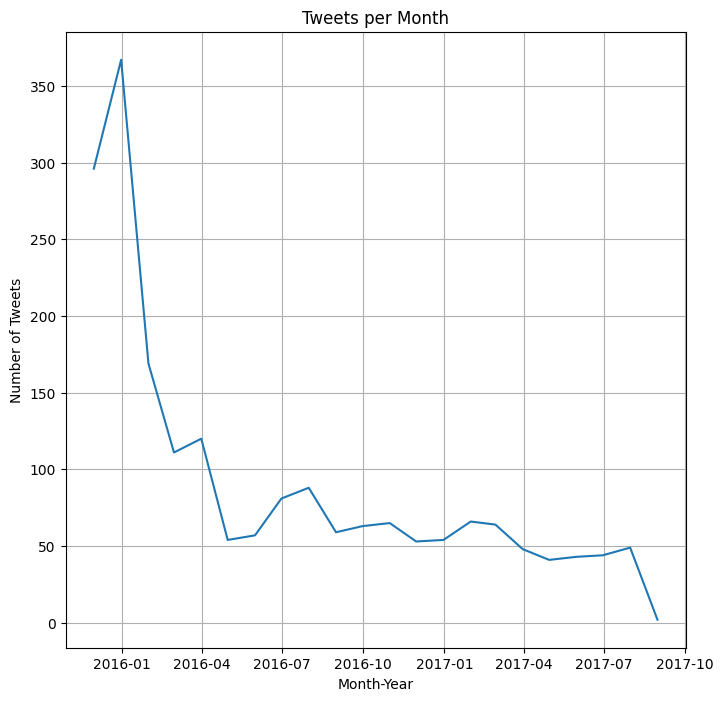

In [132]:
plt.figure(figsize=(8, 8))
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")

plt.plot(df_tweets_per_month["timestamp"], df_tweets_per_month["tweet_id"])
plt.grid(visible=True, which="major", axis="both")
plt.title("Tweets per Month");

> The number of tweets decreases substantially over time. Did people lose interest in [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs)?


#### Checking Correlation between the amount of tweets and follower counts

In [133]:
df_avg_followers = (
    df_weratedogs_all.groupby(pd.Grouper(key="timestamp", freq="M"))
    .mean()
    .reset_index()
)
df_avg_followers = df_avg_followers[["timestamp", "followers_count", "retweet_count"]]
df_avg_followers.followers_count = df_avg_followers.followers_count.astype(int)

In [134]:
df_tweet_ct_followers = df_tweets_per_month.merge(df_avg_followers, on="timestamp")
df_tweet_ct_followers.rename(columns={"tweet_id": "tweet_count"}, inplace=True)
df_tweet_ct_followers.corr()

tweet_count  followers_count  retweet_count
tweet_count         1.000000         0.834819      -0.651202
followers_count     0.834819         1.000000      -0.859924
retweet_count      -0.651202        -0.859924       1.000000

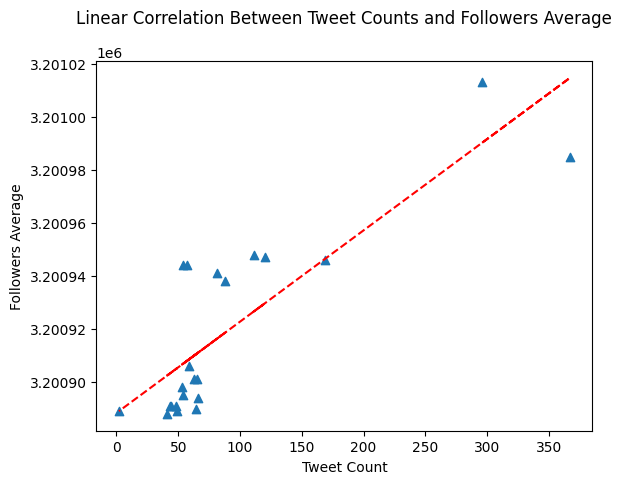

In [135]:
z = np.polyfit(
    df_tweet_ct_followers["tweet_count"], df_tweet_ct_followers["followers_count"], 1
)
p = np.poly1d(z)
plt.xlabel("Tweet Count")
plt.ylabel("Followers Average")
plt.title("Linear Correlation Between Tweet Counts and Followers Average", y=1.08)

plt.scatter(
    x=df_tweet_ct_followers["tweet_count"],
    y=df_tweet_ct_followers["followers_count"],
    marker="^",
)
plt.plot(
    df_tweet_ct_followers["tweet_count"], p(df_tweet_ct_followers["tweet_count"]), "r--"
);

> Considering that the amount of tweets vary over the month, so does the amount of followers.<br>
> The [Pearson's Ranking](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/table/T1/?report=objectonly) classifies the correlation above as a `High Positive Correlation`, which in other terms can mean, the more tweets we have, the more followers we will get.<br>
> However, it's important to be careful in this statement because **Statistical Correlation Not Necessarily Describes Causality** [reference](https://www.abs.gov.au/websitedbs/D3310114.nsf/home/statistical+language+-+correlation+and+causation#:~:text=Correlation%20is%20a%20statistical%20measure,values%20of%20the%20other%20variable.).<br>
> Therefore, a deeper investigation must be done to prove this statement

#### Number of Catalogued Breeds Followed by Confidence Level

In [136]:
# Let's discard the uncatalogued breeds
df_only_dogs = df_weratedogs_all.query("pred_dog_breed != 'Not a Dog'")

In [137]:
print(f"{df_only_dogs['pred_dog_breed'].nunique()} Distinct predicted breeds at an average confidence level of {df_only_dogs['pred_conf'].mean()}")

113 Distinct predicted breeds at an average confidence level of 0.5499357432711743


#### 10 Most Predicted Breeds

In [138]:
df_only_dogs.pred_dog_breed.value_counts().head(10)

Golden Retriever      158
Labrador Retriever    108
Pembroke               95
Chihuahua              91
Pug                    62
Toy Poodle             51
Chow                   48
Samoyed                42
Pomeranian             42
Malamute               33
Name: pred_dog_breed, dtype: int64

#### 10 Most Common Names

In [139]:
df_only_dogs_name = df_only_dogs.query("dog_name != 'None'")
df_only_dogs_name.dog_name.value_counts().head(10)

Lucy       10
Charlie    10
Cooper     10
Tucker      9
Oliver      9
Penny       8
Daisy       7
Winston     7
Sadie       7
Jax         6
Name: dog_name, dtype: int64

### Visualization

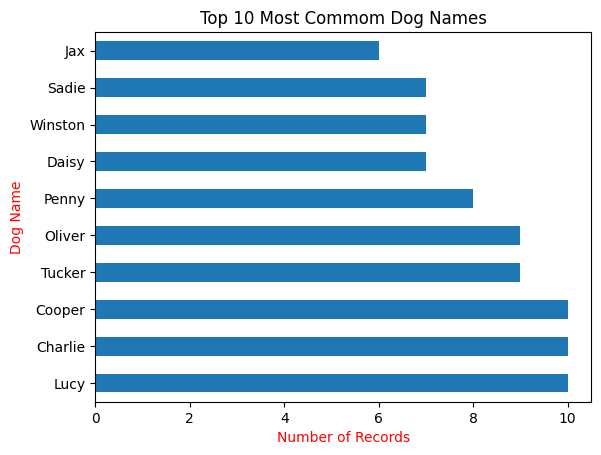

In [140]:
plt.title("Top 10 Most Commom Dog Names")
plt.xlabel("Number of Records", c = 'r')
plt.ylabel("Dog Name", c = 'r')
df_only_dogs_name.dog_name.value_counts().head(10).plot(kind = 'barh');
